# Implementação de um classificador com atributos mistos e com dados faltantes

### Aluno: Alisson da Silva Vieira

# Bibliotecas utilizadas

- Pandas: É uma biblioteca que fornece estruturas de dados rápidas, flexíveis e expressivas projetadas para tornar o trabalho com dados "relacionais" ou "rotulados" fácil e intuitivo. Tem como objetivo ser o bloco de construção fundamental de alto nível para fazer análises de dados.
- Seaborn: É uma biblioteca de visualização de dados Python baseada em matplotlib. Ele fornece uma interface de alto nível para desenhar gráficos estatísticos atraentes e informativos.
- Matplotlib: É uma biblioteca abrangente para a criação de visualizações estáticas, animadas e interativas em Python. Produz figuras com qualidade de publicação em uma variedade de formatos impressos e ambientes interativos em várias plataformas. Matplotlib pode ser usado em scripts Python, o shell Python e IPython, servidores de aplicativos da web e vários kits de ferramentas de interface gráfica do usuário.
- Scikit-learn: É uma biblioteca em Python para aprendizado de máquina desenvolvido com base no SciPy que fornece um conjunto de ferramentas de machine learning.

In [430]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Abertura do arquivo

Além de abrir o arquivo, conseguimos observar os 5 primeiros valores da base de dados.

In [431]:
df = pd.read_csv('data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Informações da base de dados

Conseguimos observar as tabelas, os tipos referente a elas e a quantidade de valores que ela possui.

Isso é importante para entedermos um pouco mais afundo dos nossos dados.

In [432]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Valores faltantes

Conseguimos ver acima, que há valores faltantes, mais especificamente nas colunas: 'Age', 'Cabin' e 'Embarked', porém a quantidade total desses valores faltantes pode ser vista abaixo:

In [433]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [434]:
f'Quantidade de valroes faltantes: {df.isnull().sum().sum()}'

'Quantidade de valroes faltantes: 866'

# Imputação

Para resolver esse problema, irei utilizar a técnica da imputação, nas colunas: 'Age' e 'Embarked' que possuem dados faltantes.

In [435]:
columns = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']
atributos_numericos = ['Age']
atributos_categoricos = ['Embarked']

transformers = [
    ('imp_num', SimpleImputer(strategy='mean'), atributos_numericos),
    ('imp_cat', SimpleImputer(strategy='constant', fill_value='desconhecido'), atributos_categoricos)
]

ct_imp = ColumnTransformer(
    transformers, remainder='drop'
)

X_imp_vals = ct_imp.fit_transform(df)

X_imputed = pd.DataFrame(X_imp_vals, columns=[*atributos_numericos, *atributos_categoricos])

Após resolvido, além da minha tabela receber os dados completos agora também removo as colunas: 'PassengerId', 'Name', 'Ticket' e 'Cabin', pois são dados que nao nos ajudam em muita coisa.

In [436]:
df['Age'] = X_imputed['Age']
df['Embarked'] = X_imputed['Embarked']

df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    object 
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(1), int64(4), object(3)
memory usage: 55.8+ KB


# Conversão dos atributos categóricos para numéricos

Os valores categoricos da coluna 'Sex' foram transformados em atributos numéricos, então a equivalência: 'male' -> 0; 'female' -> 1.

Para realizar a conversão para valores numericos, utilizei o método 'to_numeric()' do pandas para as colunas 'Age' e 'Sex'.

Quanto aos valroes da coluna 'Embarked', criei 3 novas colunas com cada um dos possíveis valores: 'Southampton', 'Cherbourg' e 'Queenstown', agora sendo atributos binários.

In [437]:
df.loc[df['Sex'] == 'male', 'Sex'] = 1
df.loc[df['Sex'] == 'female', 'Sex'] = 2

df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Sex'] = pd.to_numeric(df['Sex'], errors='coerce')

df.loc[df['Embarked'] == 'desconhecido', 'Embarked'] = 0
df.loc[df['Embarked'] == 'S', 'Embarked'] = 1
df.loc[df['Embarked'] == 'C', 'Embarked'] = 2
df.loc[df['Embarked'] == 'Q', 'Embarked'] = 3

Podemos observar os detalhes abaixo, e os 5 primeiros valores:

In [438]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 55.8+ KB
None


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,1
1,1,1,2,38.0,1,0,71.2833,2
2,1,3,2,26.0,0,0,7.9250,1
3,1,1,2,35.0,1,0,53.1000,1
4,0,3,1,35.0,0,0,8.0500,1


# Distribuição de dados

Inicialmente, por questões de visualização, irei alterar o nome dos valores da coluna 'Survived', de 0 e 1 para 'Não sobrevivente' e 'Sobrevivente'.

E plotamos os histogramas para todos os atributos do conjunto de dados.

Inicialmente defino algumas funções para auxiliar na construção dos histogramas.

In [439]:
def change(df):
    df.loc[df['Survived'] == 1, 'Survived'] = 'Sobrevivente'
    df.loc[df['Survived'] == 0, 'Survived'] = 'Não sobrevivente'

def goBack(df):
    df.loc[df['Survived'] == 'Sobrevivente', 'Survived'] = 1
    df.loc[df['Survived'] == 'Não sobrevivente', 'Survived'] = 0
    df['Survived'] = pd.to_numeric(df['Survived'], errors='coerce')

def showHistogram(df, columns):
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(8,4))

    for i, column in enumerate(columns):
        sns.histplot(data=df, bins=10, x=column, hue='Survived', multiple='dodge', shrink=0.8, ax=axes[i])

    plt.subplots_adjust(right=3.0, wspace=0.2)
    plt.show()

def showScatterplot(df, columns = ['Pclass', 'Sex', 'Age', 'SibSp',	'Parch', 'Fare', 'Embarked']):
    for idx, column in enumerate(columns):
        for col in columns[idx+1:]:
            sns.scatterplot(data=df, x=column, y=col, hue='Survived')
            plt.show()

# Histogramas

Ao plotar os histogramas, como são vistos abaixo, podemos perceber:
- Pclass (classe do bilhete):
    - Podemos perceber que, houve mais passageiros da classe 3 que da classe 2 e 1 que não sobreviveram.
- Sex:
    - Podemos perceber que há mais passageiros homens que não sobreviveram. Também percebemos que o mesmo não ocorre com as mulheres, pois o número de mulheres que sobreviveram é maior.
- Age:
    - Podemos perceber que há mais passageiros com idade entre 20 e 40 anos que não sobreviveram.
- SibSP:
    - Podemos perceber que há mais passageiros com o número de irmãos e conjugues igual a 0 que não sobreviveram.
- Parch:
    - Podemos perceber que há mais passageiros com o número de pais e filhos igual a 0 que não sobreviveram.
- Fare:
    - Podemos perceber que há mais passageiros que pagaram menos na passagem e não sobreviveram.
- Embarked:
    - Podemos perceber que há mais passageiros que partiram de Southampton que não sobreviveram.


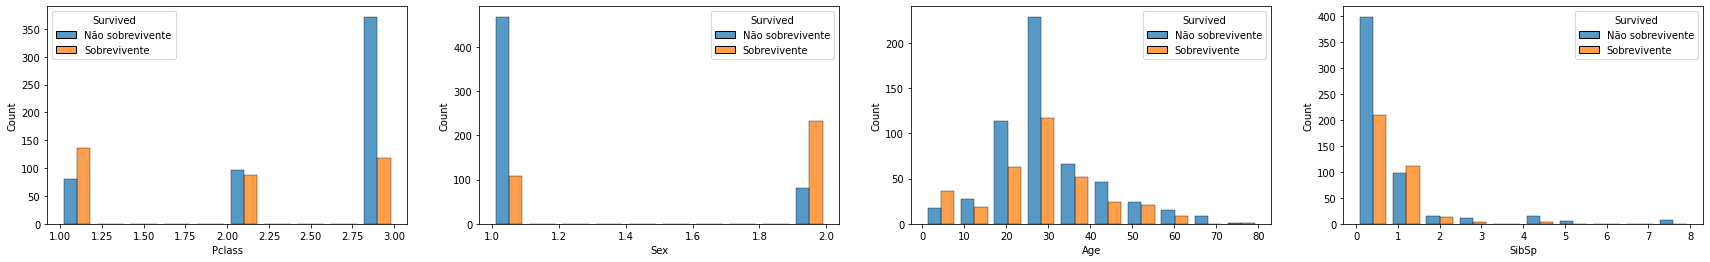

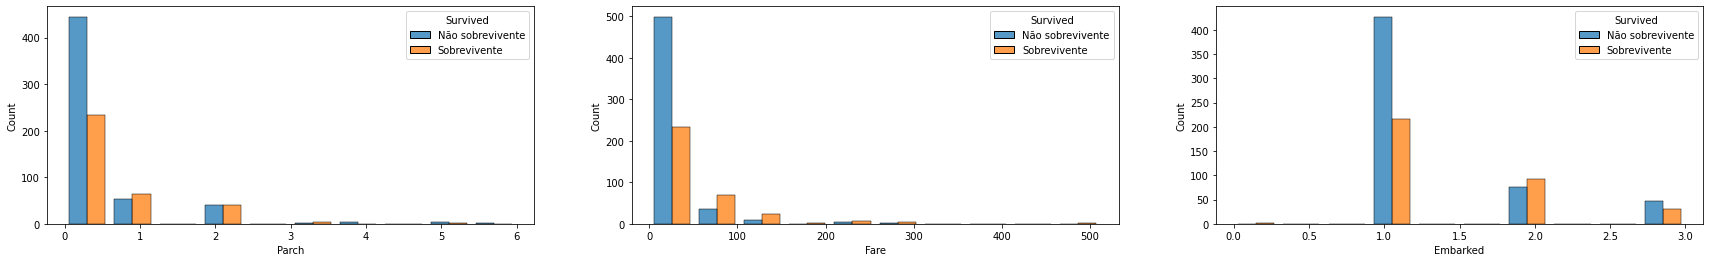

In [440]:
change(df)
showHistogram(df, ['Pclass', 'Sex', 'Age', 'SibSp'])
showHistogram(df, ['Parch', 'Fare', 'Embarked'])
goBack(df)

# Scatterplots

Para fins de se obter uma visualização mais detalhada, irei plotar os scatterplots para todos os atributos.

Podemos ver que não consiguimos perceber muita diferenciação nos scatterplots, isso pois os dados se econtram em escalas diferentes.

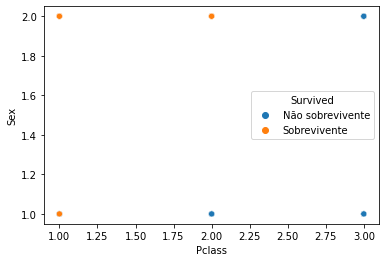

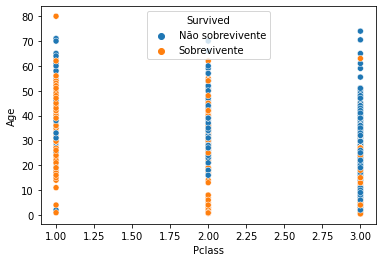

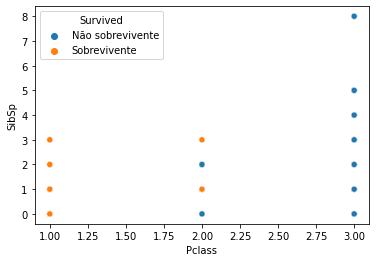

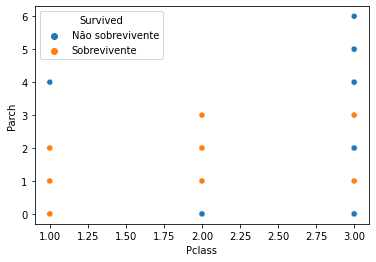

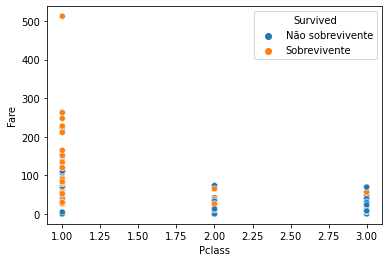

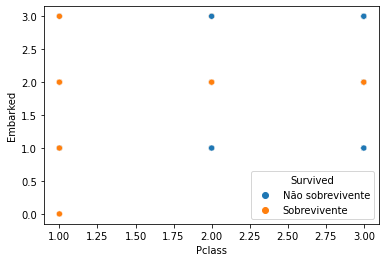

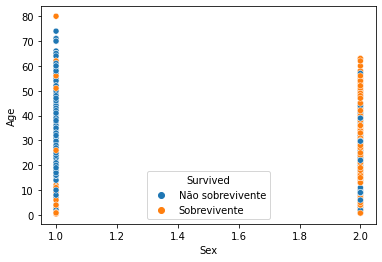

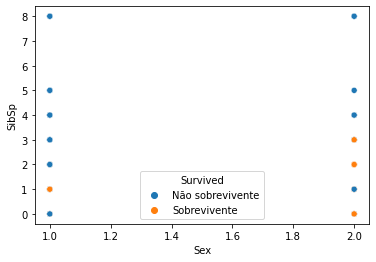

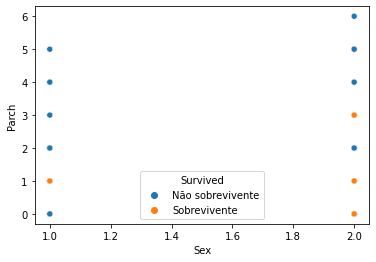

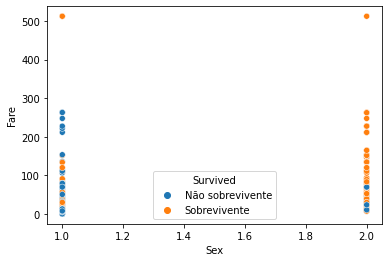

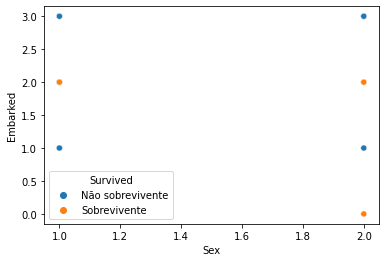

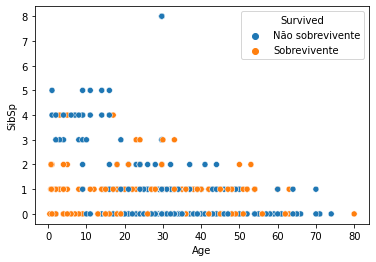

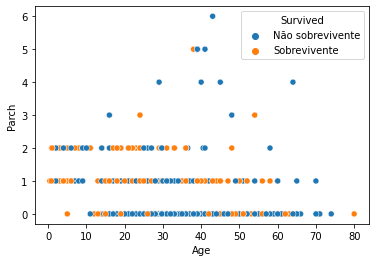

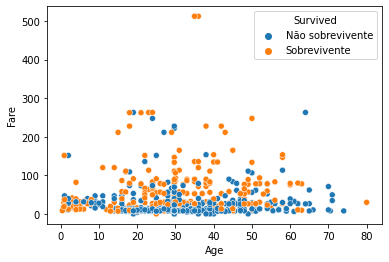

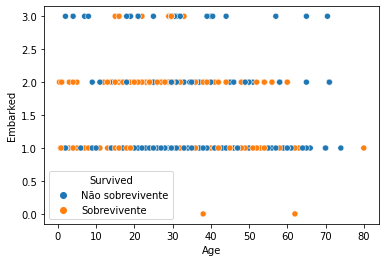

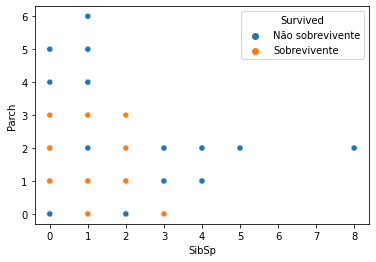

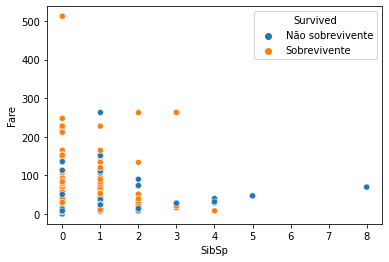

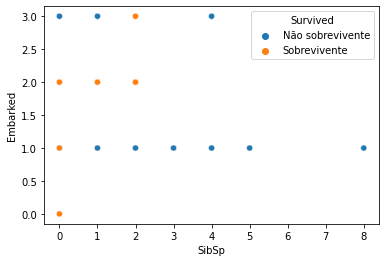

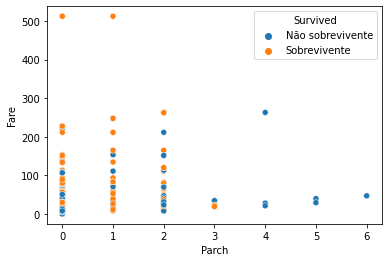

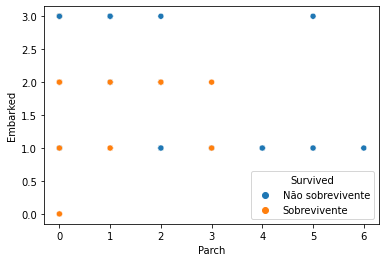

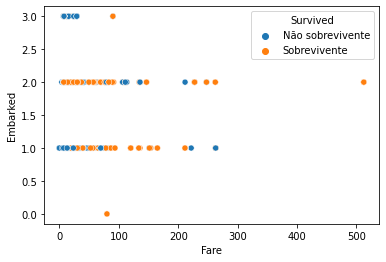

In [441]:
change(df)
showScatterplot(df)
goBack(df)

# Normalização dos dados

Foi utilizado o método StandardScaler para normalizar os dados, para que os dados fossem mais facilmente compreendidos.

Ao final do processo, podemos ver os dados normalizados, como são vistos abaixo:

In [442]:
X = df.values
y = df['Survived'].values.tolist()

scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)

dataframe = pd.DataFrame(X, columns=df.columns)
dataframe

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,-0.789272,0.827377,-0.737695,-0.592481,0.432793,-0.473674,-0.502445,-0.562619
1,1.266990,-1.566107,1.355574,0.638789,0.432793,-0.473674,0.786845,1.003923
2,1.266990,0.827377,1.355574,-0.284663,-0.474545,-0.473674,-0.488854,-0.562619
3,1.266990,-1.566107,1.355574,0.407926,0.432793,-0.473674,0.420730,-0.562619
4,-0.789272,0.827377,-0.737695,0.407926,-0.474545,-0.473674,-0.486337,-0.562619
...,...,...,...,...,...,...,...,...
886,-0.789272,-0.369365,-0.737695,-0.207709,-0.474545,-0.473674,-0.386671,-0.562619
887,1.266990,-1.566107,1.355574,-0.823344,-0.474545,-0.473674,-0.044381,-0.562619
888,-0.789272,0.827377,1.355574,0.000000,0.432793,2.008933,-0.176263,-0.562619
889,1.266990,-1.566107,-0.737695,-0.284663,-0.474545,-0.473674,-0.044381,1.003923


# PCA

O PCA é um algoritmo de redução de dimensionalidade, e o mesmo é implementado logo abaixo.

Podemos observar a redução de dimensionalidade logo apos a execução.

In [460]:
pca = PCA(n_components=2) # dimensoes
pca.fit(X)

X_pca = pca.transform(X)
X_pca_df = pd.DataFrame(X_pca, columns=['PC 0', 'PC 1'])

print(f'Instâncias priginais: {str(X.shape)}\nInstâncias projetadas nos componentes principais: {str(X_pca_df.shape)}')

Instâncias priginais: (891, 8)
Instâncias projetadas nos componentes principais: (891, 2)


O gráfico logo abaixo, é a projeção do PCA sobre os 2 primeiros componentes principais a partir de todos os atributos originais do dataset.

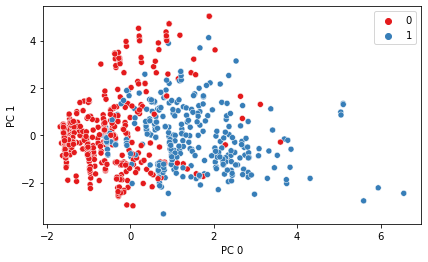

In [451]:
sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC 0', y='PC 1', hue=y, palette='Set1')
plt.subplots_adjust(right=1.0)
plt.show()